In [ ]:
!pip install lazypredict
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16318 entries, 0 to 16317
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Dir              16318 non-null  object 
 1   Flgs             16318 non-null  object 
 2   SrcAddr          16318 non-null  object 
 3   DstAddr          16318 non-null  object 
 4   Sport            16318 non-null  object 
 5   Dport            16318 non-null  int64  
 6   SrcBytes         16318 non-null  int64  
 7   DstBytes         16318 non-null  int64  
 8   SrcLoad          16318 non-null  float64
 9   DstLoad          16318 non-null  float64
 10  SrcGap           16318 non-null  int64  
 11  DstGap           16318 non-null  int64  
 12  SIntPkt          16318 non-null  float64
 13  DIntPkt          16318 non-null  float64
 14  SIntPktAct       16318 non-null  float64
 15  DIntPktAct       16318 non-null  int64  
 16  SrcJitter        16318 non-null  float64
 17  DstJitter   

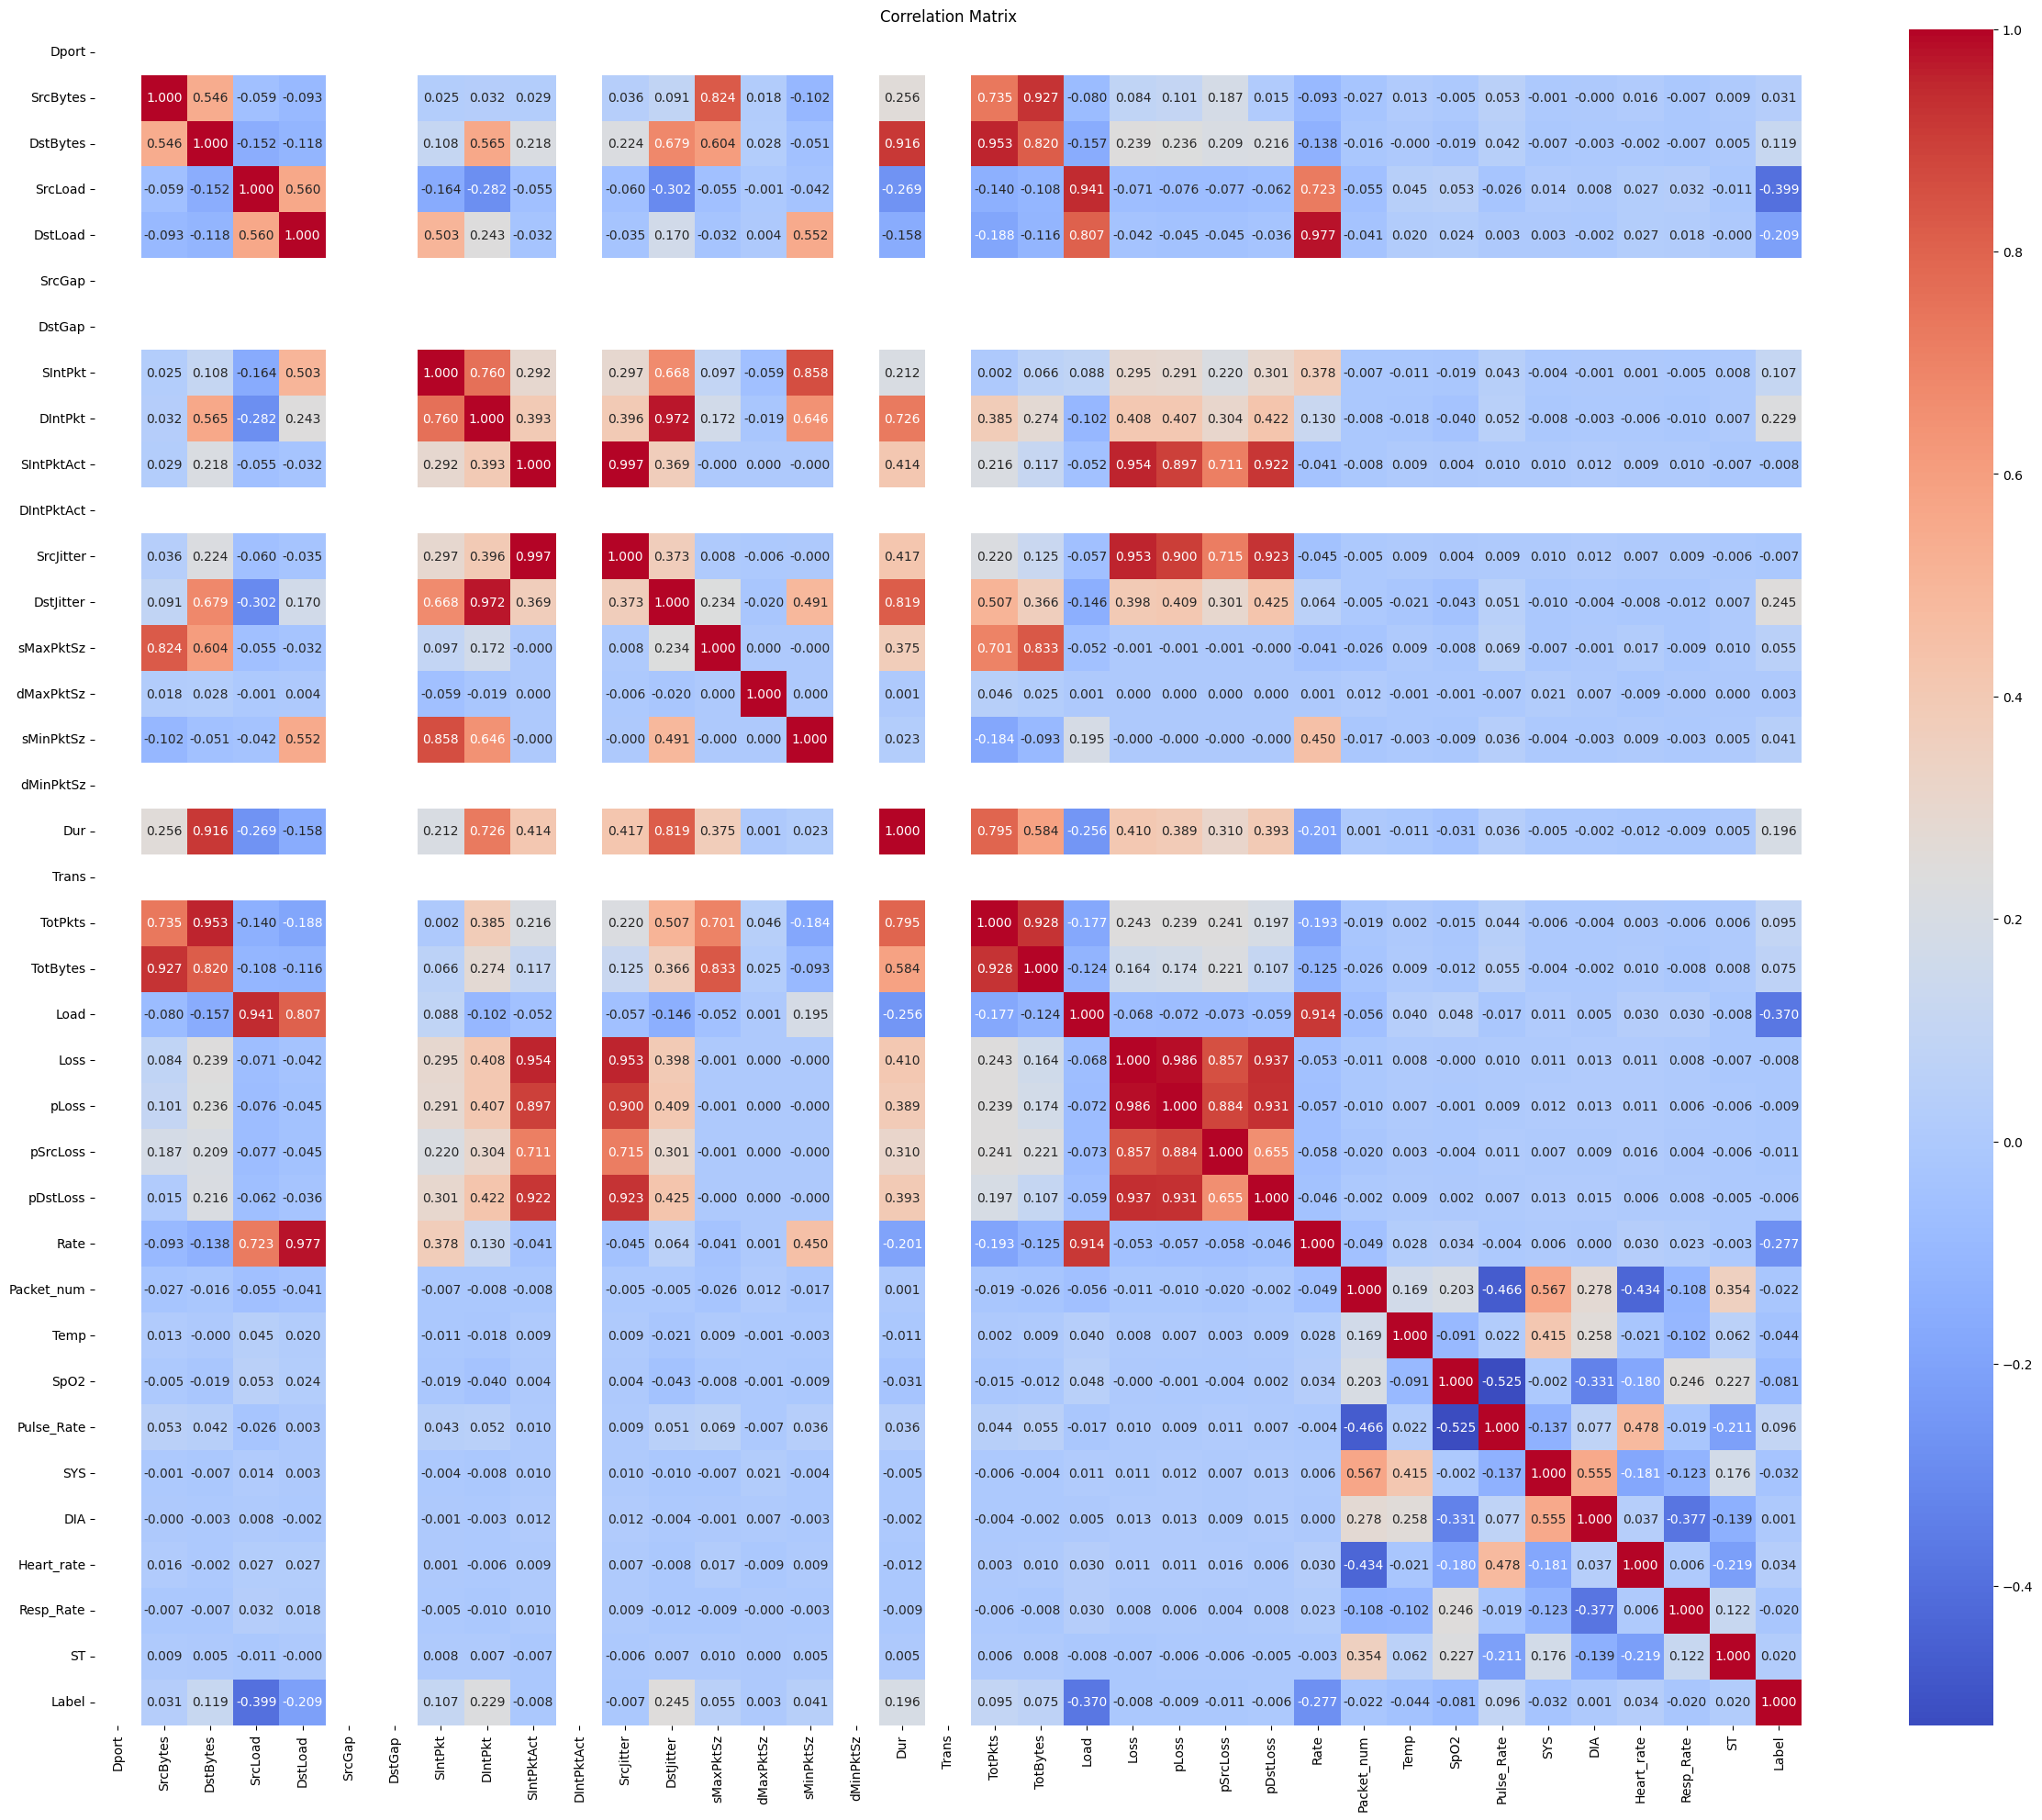

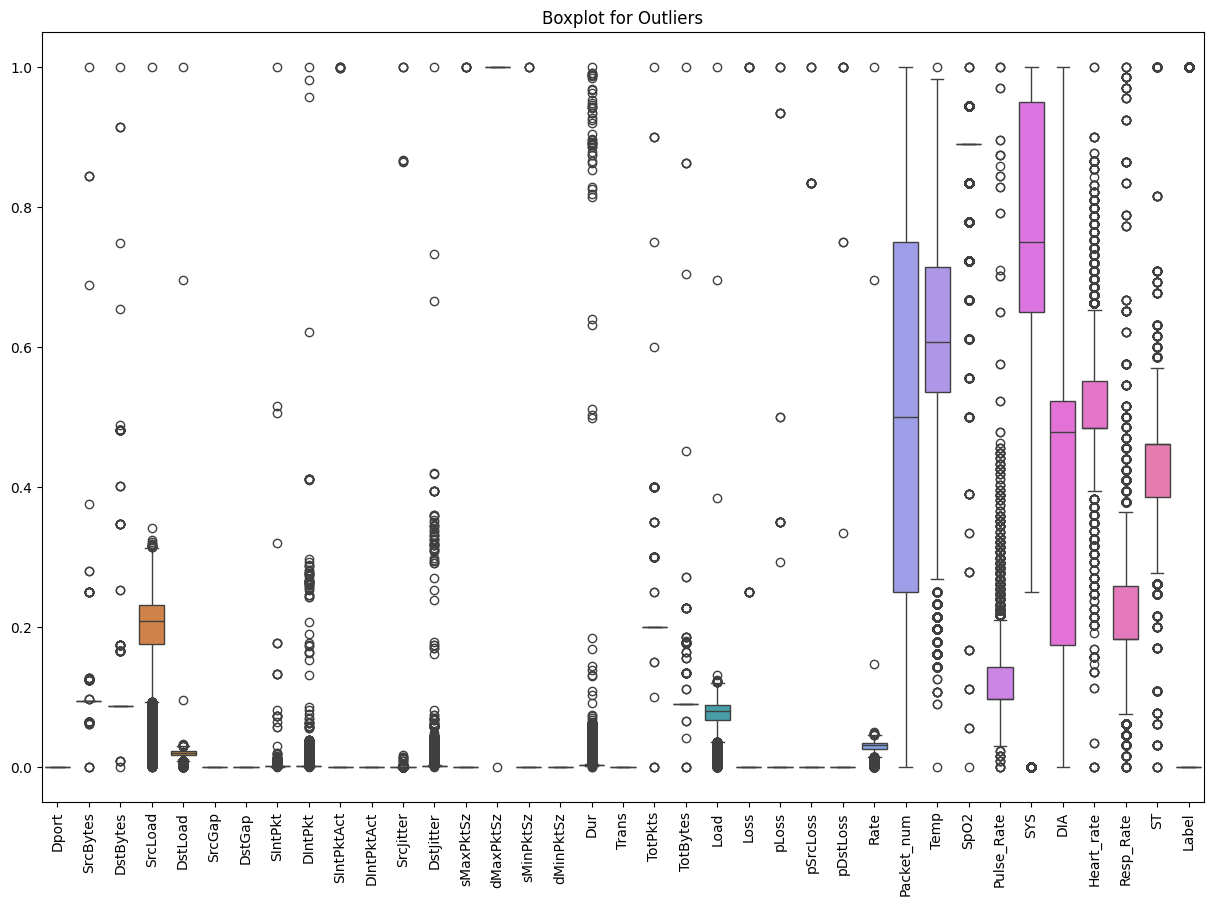

Anomalies in Training Data: 572
Anomalies in Testing Data: 257
Clean Training Data Size: (10850, 16356)
Clean Testing Data Size: (4639, 16356)


 97%|█████████▋| 31/32 [00:32<00:00,  1.44it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2844
[LightGBM] [Info] Number of data points in the train set: 10850, number of used features: 18
[LightGBM] [Info] Start training from score -4.371939
[LightGBM] [Info] Start training from score -2.675855
[LightGBM] [Info] Start training from score -0.084986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 32/32 [00:33<00:00,  1.05s/it]

Model Comparison:
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
BaggingClassifier                  0.96               0.85    None      0.96   
LGBMClassifier                     0.95               0.82    None      0.95   
LabelPropagation                   0.94               0.80    None      0.94   
DecisionTreeClassifier             0.92               0.80    None      0.92   
LabelSpreading                     0.94               0.80    None      0.94   
KNeighborsClassifier               0.93               0.76    None      0.92   
GaussianNB                         0.51               0.74    None      0.62   
NearestCentroid                    0.65               0.71    None      0.73   
QuadraticDiscriminantAnalysis      0.51               0.71    None      0.62   
ExtraTreeClassifier                0.88               0.70    None      0.88   
RandomForestClassifier

In [ ]:
# Step 1: Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import OneClassSVM
from lazypredict.Supervised import LazyClassifier

# Step 2: Load the dataset
file_path = "wustl-ehms-2020_with_attacks_categories.csv"
data = pd.read_csv(file_path)

# Step 3: Check for missing values and zeros
print(data.info())
print("Missing values:\n", data.isnull().sum())
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
zero_values = (data[numeric_columns] == 0).sum()
print("Zero values in numerical columns:\n", zero_values)

# Step 4: Handle missing values and zeros
# Handling missing values using SimpleImputer (for more advanced methods)
imputer = SimpleImputer(strategy='mean')  # For numeric columns
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Replace zeros with median for specific columns to avoid bias
columns_to_replace_zeros = ['SpO2', 'Pulse_Rate', 'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST']
for col in columns_to_replace_zeros:
    if col in numeric_columns:
        data[col] = data[col].replace(0, data[col].median())

# Handle non-numeric columns (e.g., categorical data) by filling with mode
non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Step 5: Data Normalization (MinMaxScaler)
scaler = MinMaxScaler()
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Step 6: Encoding categorical variables
label_encoder = LabelEncoder()
data['Attack Category'] = label_encoder.fit_transform(data['Attack Category'])

# Step 7: EDA (Exploratory Data Analysis)
# Correlation matrix
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(30, 24))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Boxplot for outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=data[numeric_columns])
plt.xticks(rotation=90)
plt.title("Boxplot for Outliers")
plt.show()

# Step 8: Splitting the dataset
X = data.drop(['Attack Category', 'Label'], axis=1)
y = data['Attack Category']

# Ensure all columns are numeric by encoding categorical data
X = pd.get_dummies(X, drop_first=True)

# Split the dataset into train and test sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 9: Anomaly Detection (Isolation Forest)
iso_forest = IsolationForest(random_state=42, contamination=0.05)  # 5% expected anomalies
iso_forest.fit(X_train)

# Predict anomalies in training and testing data
train_anomalies = iso_forest.predict(X_train)
test_anomalies = iso_forest.predict(X_test)

# Count anomalies
train_outliers = sum(train_anomalies == -1)
test_outliers = sum(test_anomalies == -1)
print(f"Anomalies in Training Data: {train_outliers}")
print(f"Anomalies in Testing Data: {test_outliers}")

# Filter only normal data
X_train['Anomaly'] = train_anomalies
X_test['Anomaly'] = test_anomalies

X_train_clean = X_train[X_train['Anomaly'] == 1].drop(columns=['Anomaly'])
y_train_clean = y_train[X_train['Anomaly'] == 1]
X_test_clean = X_test[X_test['Anomaly'] == 1].drop(columns=['Anomaly'])
y_test_clean = y_test[X_test['Anomaly'] == 1]

print(f"Clean Training Data Size: {X_train_clean.shape}")
print(f"Clean Testing Data Size: {X_test_clean.shape}")

# Step 10: Lazy Predict for model comparison
clf = LazyClassifier()
models, predictions = clf.fit(X_train_clean, X_test_clean, y_train_clean, y_test_clean)
print("Model Comparison:")
print(models)

# Step 11: Compute class weights after anomaly removal
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_clean), y=y_train_clean)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Step 12: Hyperparameter Tuning (GridSearchCV)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(class_weight=class_weights_dict, random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_clean, y_train_clean)
print("Best Hyperparameters:", grid_search.best_params_)

# Step 13: Training the best model (Random Forest with class weights)
rf = RandomForestClassifier(class_weight=class_weights_dict, **grid_search.best_params_, random_state=42)
rf.fit(X_train_clean, y_train_clean)
y_pred_clean = rf.predict(X_test_clean)

# Step 14: Evaluation (Classification Report & Metrics)
print("\nClassification Report (Random Forest with Class Weights):")
print(classification_report(y_test_clean, y_pred_clean))
print("\nAccuracy:", accuracy_score(y_test_clean, y_pred_clean))
print("\nF1 Score:", f1_score(y_test_clean, y_pred_clean, average='weighted'))
print("\nPrecision Score:", precision_score(y_test_clean, y_pred_clean, average='weighted'))
print("\nRecall Score:", recall_score(y_test_clean, y_pred_clean, average='weighted'))

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test_clean, y_pred_clean)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test_clean, rf.predict_proba(X_test_clean)[:, 1], pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# Step 15: Ensemble Models (Boosting)
# AdaBoost Classifier
ada_boost = AdaBoostClassifier(random_state=42)
ada_boost.fit(X_train_clean, y_train_clean)
y_pred_ada = ada_boost.predict(X_test_clean)
print("\nAdaBoost Classifier - Accuracy:", accuracy_score(y_test_clean, y_pred_ada))

# Confusion Matrix for AdaBoost
conf_matrix_ada = confusion_matrix(y_test_clean, y_pred_ada)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ada, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - AdaBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for AdaBoost
fpr_ada, tpr_ada, _ = roc_curve(y_test_clean, ada_boost.predict_proba(X_test_clean)[:, 1], pos_label=1)
roc_auc_ada = auc(fpr_ada, tpr_ada)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ada, tpr_ada, color='green', lw=2, label=f'AdaBoost (AUC = {roc_auc_ada:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AdaBoost')
plt.legend(loc='lower right')
plt.show()

# Gradient Boosting Classifier
grad_boost = GradientBoostingClassifier(random_state=42)
grad_boost.fit(X_train_clean, y_train_clean)
y_pred_grad = grad_boost.predict(X_test_clean)
print("\nGradient Boosting Classifier - Accuracy:", accuracy_score(y_test_clean, y_pred_grad))

# Optional: Further Ensemble Methods like XGBoost can be added here
